In [1]:
# For Analysis
import numpy as np
import pandas as pd

# For Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# For Calculations
from math import floor

#For Feature Selection
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel
from boruta import BorutaPy

#For Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import LinearSVC

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

from sklearn import cluster

# For Validation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

%matplotlib inline

## Importing and looking at the Data

Reading in the datasets

In [2]:
listings = pd.read_csv('../data/airbnb_listings.csv')
stations = pd.read_csv('../data/train_stations.csv')
neighbourhoods = pd.read_csv('../data/neighbourhood_score.csv')
attractions = pd.read_csv('../data/attractions.csv')

In [3]:
listings.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,Neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [4]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
id                        74111 non-null int64
log_price                 74111 non-null float64
property_type             74111 non-null object
room_type                 74111 non-null object
amenities                 74111 non-null object
accommodates              74111 non-null int64
bathrooms                 73911 non-null float64
bed_type                  74111 non-null object
cancellation_policy       74111 non-null object
cleaning_fee              74111 non-null bool
city                      74111 non-null object
description               74111 non-null object
first_review              58247 non-null object
host_has_profile_pic      73923 non-null object
host_identity_verified    73923 non-null object
host_response_rate        55812 non-null object
host_since                73923 non-null object
instant_bookable          74111 non-null object
last_review               582

There were no detailed descriptions given along with the dataset other than for id and log_price. Thus we need to do some EDA to identify the different features.
 We observe that, the following columns need to be changed to the correect data type.
- id to string
- first_review, host_since, last_review to date.
- instant_bookable, host_identity_verified, host_has_profie_pictore to Number encoded values.
- host_response_rate to a numerical column.

Some of the things to check
- Distributions of the variables
- Whether there are duplicates in the zip code
- Clusters in the data
- There are some facilities with the same names and same descriptions. 


In [5]:
# Check the statistical distribution for Numerical Columns
listings.describe()

,id,log_price,accommodates,bathrooms,latitude,longitude,number_of_reviews,review_scores_rating,bedrooms,beds
count,7.411100e+04,74111.000000,74111.000000,73911.000000,74111.000000,74111.000000,74111.000000,57389.000000,74020.000000,73980.000000
mean,1.126662e+07,4.782069,3.155146,1.235263,38.445958,-92.397525,20.900568,94.067365,1.265793,1.710868
std,6.081735e+06,0.717394,2.153589,0.582044,3.080167,21.705322,37.828641,7.836556,0.852143,1.254142
min,3.440000e+02,0.000000,1.000000,0.000000,33.338905,-122.511500,0.000000,20.000000,0.000000,0.000000
25%,6.261964e+06,4.317488,2.000000,1.000000,34.127908,-118.342374,1.000000,92.000000,1.000000,1.000000
50%,1.225415e+07,4.709530,2.000000,1.000000,40.662138,-76.996965,6.000000,96.000000,1.000000,1.000000
75%,1.640226e+07,5.220356,4.000000,1.000000,40.746096,-73.954660,23.000000,100.000000,1.000000,2.000000
max,2.123090e+07,7.600402,16.000000,8.000000,42.390437,-70.985047,605.000000,100.000000,10.000000,18.000000


In [6]:
# Check the distribution of Categorical and Text columns
listings.describe(include = ["O"])

,property_type,room_type,amenities,bed_type,cancellation_policy,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,name,Neighbourhood,thumbnail_url,zipcode
count,74111,74111,74111,74111,74111,74111,74111,58247,73923,73923,55812,73923,74111,58284,74111,74111,65895,73529
unique,35,3,67122,5,5,6,73472,2554,2,2,80,3087,2,1371,73350,1722,65883,673
top,Apartment,Entire home/apt,{},Real Bed,strict,NYC,"Hello, I've been running guest house for Korea...",1/1/2017,t,t,100%,3/30/2015,f,4/30/2017,#NAME?,Williamsburg,https://a0.muscache.com/im/pictures/70087089/b...,11211
freq,49003,41310,586,72028,32374,32349,8,293,73697,49748,43254,246,54660,1344,10,2862,3,1618


In [7]:
listings.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'description', 'first_review',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'host_since', 'instant_bookable', 'last_review', 'latitude',
       'longitude', 'name', 'Neighbourhood', 'number_of_reviews',
       'review_scores_rating', 'thumbnail_url', 'zipcode', 'bedrooms', 'beds'],
      dtype='object')

In [8]:
lower_dim_categories = ['property_type', 'room_type', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
[listings[c].value_counts() for c in lower_dim_categories]

[Apartment             49003
 House                 16511
 Condominium            2658
 Townhouse              1692
 Loft                   1244
 Other                   607
 Guesthouse              498
 Bed & Breakfast         462
 Bungalow                366
 Villa                   179
 Dorm                    142
 Guest suite             123
 Camper/RV                94
 Timeshare                77
 Cabin                    72
 In-law                   71
 Hostel                   70
 Boutique hotel           69
 Boat                     65
 Serviced apartment       21
 Tent                     18
 Castle                   13
 Vacation home            11
 Yurt                      9
 Hut                       8
 Treehouse                 7
 Chalet                    6
 Earth House               4
 Tipi                      3
 Train                     2
 Cave                      2
 Parking Space             1
 Island                    1
 Casa particular           1
 Lighthouse   

We convert the following features to the right format.
- **id** : Integer to String
- **first_review** : String to Datetime
- **last_review** : String to Datetime
- **host_since** : String to Datetime



In [9]:
def pp_fix_dtypes(df):
    #Correct the types of the data where required
    df = df.assign(
        id = df.id.astype(str),
        first_review = pd.to_datetime(df.first_review),
        last_review = pd.to_datetime(df.last_review),
        host_since = pd.to_datetime(df.host_since)
    )
    return df
    

In [10]:
listings = pp_fix_dtypes(listings)

### Support Functions

In [11]:
def get_max_date(df):
    most_recent_date = max(
            max(df.host_since),
            max(df.first_review),
            max(df.last_review)
        )
    return most_recent_date

In [12]:
most_recent_date = get_max_date(listings)

In [13]:
def show_cols_with_missing(df):
    missing_vals = df.isnull().sum().sort_values(ascending = False)
    
    return missing_vals.iloc[missing_vals.nonzero()[0]]

### Functions for handling Missing Values

In [14]:
show_cols_with_missing(listings)

host_response_rate        18299
review_scores_rating      16722
first_review              15864
last_review               15827
thumbnail_url              8216
zipcode                     582
bathrooms                   200
host_identity_verified      188
host_has_profile_pic        188
host_since                  188
beds                        131
bedrooms                     91
dtype: int64

In [15]:
listings[['host_since','first_review','last_review']].describe()

,host_since,first_review,last_review
count,73923,58247,58284
unique,3087,2554,1371
top,2015-03-30 00:00:00,2017-01-01 00:00:00,2017-04-30 00:00:00
freq,246,293,1344
first,2008-03-03 00:00:00,2008-11-17 00:00:00,2009-01-21 00:00:00
last,2017-10-04 00:00:00,2017-10-05 00:00:00,2017-10-05 00:00:00


**Notes for handling Missing Values**

host_since:
- Take the date of first_review where avilable.
- In some records, the date of first review is before the host_date. It is possible that 
    - the listing was changed at a later date - Update first_review date to host_date
    - the dates were read in the wrong order - Swap the first_review_date and host_date

In [16]:
def handle_missing(df):
    temp_df = df.copy()
    
    # Fill the Host Since column with the date of first review if available
    temp_df.host_since = df.host_since.fillna(df.first_review)
    
    # Fill the Thumbnails Column and recode it 
    temp_df.thumbnail_url.fillna(0, inplace=True)
    temp_df.loc[temp_df.thumbnail_url != 0, ['thumbnail_url']] = 1
    
    # Fill missing values for some columns with 0
    temp_df.bedrooms.fillna(0, inplace = True)
    temp_df.bathrooms.fillna(0, inplace = True)
    temp_df.beds.fillna(0, inplace = True)
    
    # Drop the rows with missing values for particular  columns
    temp_df.dropna(subset = ['host_since','host_has_profile_pic'], inplace = True)
    
    # Drop the columns that have a lot of missing values and are not useful for analysis
    #temp_df.drop(['first_review','last_review','zipcode'], axis = 1, inplace = True)
    
    return temp_df

In [17]:
listings = handle_missing(listings)
show_cols_with_missing(listings)

host_response_rate      18111
review_scores_rating    16675
first_review            15822
last_review             15791
zipcode                   580
dtype: int64

### Data Preprocessing

**Function for calculating distance to attractions**

We have the attractions.csv file that contains the lat long of top 3 attractions in each of the 6 states. We us this to calculate the distance from the listing to each of those locations.

In [18]:
#https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
def haversine_np(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6372.8 * c
    return km

In [19]:
# Check the structure of the attractions data
attractions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 10 columns):
city                6 non-null object
attraction1         6 non-null object
attraction1_lat     6 non-null float64
attraction1_long    6 non-null float64
attraction2         6 non-null object
attraction2_lat     6 non-null float64
attraction2_long    6 non-null float64
attraction3         6 non-null object
attraction3_lat     6 non-null float64
attraction3_long    6 non-null float64
dtypes: float64(6), object(4)
memory usage: 560.0+ bytes


**Function to calculate distance to attractions given the LatLong**

In [20]:
def calc_dist_to_attractions(df):
    df = pd.merge(df,attractions, on='city', how="left", indicator=False)
    df = df.assign(
        dist_to_attr1 = haversine_np(df["attraction1_lat"],df["attraction1_long"],df["latitude"],df["longitude"]),
        dist_to_attr2 = haversine_np(df["attraction2_lat"],df["attraction2_long"],df["latitude"],df["longitude"]),
        dist_to_attr3 = haversine_np(df["attraction3_lat"],df["attraction3_long"],df["latitude"],df["longitude"])
    )
    df.drop(["attraction1","attraction2","attraction3", "attraction1_lat","attraction1_long","attraction2_lat","attraction2_long","attraction3_lat","attraction3_long" ],axis = 1,inplace = True) 
    return df

**Function to calculate distance to closest railway station given the LatLong**

In [21]:
def calc_dist_to_closest_station(df):
    
    # Rename Columns in the stations dataset
    stations.columns = ['city', 'station_name', 'station_lat', 'station_long']
    
    # join with selected columns from the listings dataset
    df1 = df[['id','city','latitude','longitude']].merge(stations, on='city', how="inner", indicator=False)
    
    # Calculate the distance and save to a new column
    df1 = df1.assign(
        dist_to_station = haversine_np(df1["station_lat"],df1["station_long"],df1["latitude"],df1["longitude"])
    )
    
    
    df2 = df1.sort_values(['id', 'dist_to_station']).drop_duplicates(['id'])
    df1 = df.merge(df2[['id','dist_to_station']], on ="id", how = "inner", indicator = False)
    return df1

In [22]:
# Update Listings with the new columns
listings = calc_dist_to_attractions(listings)   
listings = calc_dist_to_closest_station(listings)   
    
listings.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds,dist_to_attr1,dist_to_attr2,dist_to_attr3,dist_to_station
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,2,100.0,1,11201,1.0,1.0,4.533604,9.858104,6.974862,0.162282
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,6,93.0,1,10019,3.0,3.0,9.748908,2.729491,0.878994,0.481606
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,10,92.0,1,10027,1.0,3.0,15.715851,3.344257,6.450707,0.151675
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,0,NaN,1,94117,2.0,2.0,6.724060,6.163671,4.509624,1.302130
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,4,40.0,0,20009,0.0,1.0,3.110579,4.260263,4.061666,0.373534


**Function to preprocess the features**

In [23]:
# Controls for the below function
recode_features = True

In [24]:
# Function to Preprocess the Data
def preprocess(df, test_data = False):
    
    global recode_features, most_recent_date
    
    temp_df = df.copy()
    
    #Recode features where required
    if recode_features == True:
        temp_df = temp_df.replace(
            {
            'host_has_profile_pic': {'t': True, 'f': False},
            'host_identity_verified': {'t': True, 'f': False},
            'instant_bookable': {'t': True, 'f': False},
            'cancellation_policy': {'super_strict_30':'strict','super_strict_60':'strict'}
            }
        )
        
        ## Recode propoerty_type
        def recode_prop(value):
            if value not in ['House', 'Apartment']:
                return 'other_prop_type'
            return value

        temp_df['property_type'] = temp_df['property_type'].apply(recode_prop)

        ## Recode bed_type
        def recode_bed(value):
            if value not in ['Real Bed']:
                return 'other_bed_type'
            return value

        temp_df['bed_type'] = temp_df['bed_type'].apply(recode_bed)
    
        recode_features = False
    
    #Convert date fields into days_since and useful components
    ## Calculate the Maximum Date Present in the Data
    if test_data == False:
        most_recent_date = get_max_date(temp_df)
    print("Reference Date Used: ", most_recent_date)
    
    ## Derive the new columns
    temp_df = temp_df.assign(
        year_of_listing = temp_df.host_since.dt.year,
        month_of_listing = temp_df.host_since.dt.month,
        days_since_hosted = (most_recent_date - temp_df.host_since)/np.timedelta64(1, 'D'),
        price = np.exp(listings['log_price']),
        host_response_rate = temp_df.host_response_rate.str.strip('%').astype(float)/100
        
        #days_since_first_review = (most_recent_date - temp_df.first_review)/np.timedelta64(1, 'D'),
        #days_since_last_review = (most_recent_date - temp_df.last_review)/np.timedelta64(1, 'D')
    )
    
    # Calculate the bedroom and bathroom share per person. Higher the share, more the comfort.
    temp_df = temp_df.assign(
        bedroom_share = temp_df.bedrooms/temp_df.accommodates,
        bathroom_share = temp_df.bathrooms/temp_df.accommodates
    )
    
    # Drop the Features that are not needed
    #temp_df.drop(['beds', 'bedrooms', 'bathrooms', 'first_review','last_review','zipcode' ], axis = 1, inplace = True)
    
    df = temp_df
    print("Preprocessing Completed")
    
    return df

In [25]:
# Preprocess the Listings data
listings = preprocess(listings)

Reference Date Used:  2017-10-05 00:00:00
Preprocessing Completed


In [26]:
# Create Dummy Columns
def create_dummies(df, columns = ['room_type', 'city', 'property_type', 'bed_type', 'cancellation_policy']):
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix = column)
        df = pd.concat([df,dummies], axis = 1)
    return df

In [27]:
# Create the required dummy columns, By default creates for 'room_type' and 'city'
listings = create_dummies(listings)

#### Add in Columns from Topic Modeling

In [28]:
# Read in the data
description_data = pd.read_csv("../data/airbnb_listings_LDA.csv")

In [29]:
# Check the column names
description_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 8 columns):
id                     74111 non-null int64
description            74111 non-null object
Description_Length     74111 non-null float64
Sentiment_intensity    74111 non-null float64
LDA_attractions        74111 non-null float64
LDA_transport          74111 non-null float64
LDA_amenities          74111 non-null float64
LDA_property_desc      74111 non-null float64
dtypes: float64(6), int64(1), object(1)
memory usage: 4.5+ MB


In [30]:
# Rename Columns to standard format
description_data.columns = ['id', 'description', 'description_length', 
                            'sentiment_intensity', 'lda_attractions', 
                            'lda_transport', 'lda_amenities', 'lda_property_desc']

# Change data type of id column
description_data.id = description_data.id.astype(str)

# Drop the description column to avoid duplicates
description_data.drop('description', axis = 1, inplace = True)

# Join the Data from Descriptions to the listings data
listings = listings.merge(description_data, how = "inner", on = 'id')

# Drop the description column in listings data as that is no longer required
listings.drop('description', axis = 1, inplace = True)


#### Pre-Processing AMENITIES

In [31]:
#Blank missing values in Amenities column
listings.loc[listings['amenities'] == '{}','amenities'] = ""

#Remove the symbols and one hot encode the amenities feature
listings['amenities'] = listings['amenities'].map(
    lambda amns: "|".join([amn.replace("}", "").replace("{", "").replace('"', "")\
                           for amn in amns.split(",")]))

amenities = np.unique(np.concatenate(listings['amenities'].map(lambda amns: amns.split("|")).values))

amenities_matrix = np.array([listings['amenities'].map(lambda amns: amn in amns).values for amn in amenities])
amen=pd.DataFrame(data=amenities_matrix.T, columns=amenities)

In [32]:
#Find important features from the amenities for target price prediction
listings_amenities = pd.concat([amen,listings[['id','log_price']]], axis=1)

In [33]:
listings_amenities.head()

,,smooth pathway to front door,24-hour check-in,Accessible-height bed,Accessible-height toilet,Air conditioning,Air purifier,BBQ grill,Baby bath,Baby monitor,...,Wide clearance to shower and toilet,Wide doorway,Wide entryway,Wide hallway clearance,Window guards,Wireless Internet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50,id,log_price
0,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,True,6901257,5.010635
1,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,True,6304928,5.129899
2,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,True,7919400,4.976734
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,13418779,6.620073
4,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,3808709,4.744932


In [34]:
#Remove junk amenities from the created features
listings_amenities=listings_amenities.drop(columns=['','translation missing: en.hosting_amenity_49','translation missing: en.hosting_amenity_50'])

#Convert the amenities table into long format
listings_amenities_long = listings_amenities.melt(id_vars=['id', 'log_price'], var_name='amenity')

Take a count of all the amenities present in the Data

In [35]:
amenity_counts = listings_amenities.drop(['id','log_price'], axis = 1).sum(axis = 0)

We can explore that data using the below code. Kept for reference and Debugging

In [36]:
amenity_counts.sort_values(ascending = False)[['Flat',' smooth pathway to front door']]

Flat                             406
 smooth pathway to front door    406
dtype: int64

We observe that the above 2 columns are most probably the same.

In [37]:
listings_amenities[['EV charger','Free parking on premises','Free parking on street','Paid parking off premises']].corr()

,EV charger,Free parking on premises,Free parking on street,Paid parking off premises
EV charger,1.000000,0.007153,-0.000832,-0.000251
Free parking on premises,0.007153,1.000000,-0.006835,-0.006668
Free parking on street,-0.000832,-0.006835,1.000000,-0.000314
Paid parking off premises,-0.000251,-0.006668,-0.000314,1.000000


Looking at the correlation is not really useful for categorical values. Thus we explore the amenities using Two Way tables

In [38]:
pd.crosstab(listings_amenities['Coffee maker'],listings_amenities['Refrigerator'])

Refrigerator,False,True
Coffee maker,,
False,69243,1132
True,42,3506


In [39]:
# The Dictionary for Recoding Amenities

## The original Amenities grouped by their nature.
amenitiy_recodings = {
    'Flat' : 'Accessible Room',
    ' smooth pathway to front door' : 'Accessible Room',
    'Accessible-height bed' : 'Accessible Room', 
    'Accessible-height toilet'  : 'Accessible Room',
    'Flat smooth pathway to front door'  : 'Accessible Room',
    'Fixed grab bars for shower & toilet'  : 'Accessible Room',
    'Grab-rails for shower and toilet'  : 'Accessible Room', 
    'Step-free access'  : 'Accessible Room',
    'Wheelchair accessible'  : 'Accessible Room',
    'Wide clearance to bed'  : 'Accessible Room', 
    'Wide clearance to shower & toilet'  : 'Accessible Room',
    'Wide clearance to shower and toilet'  : 'Accessible Room',
    'Wide doorway'  : 'Accessible Room',
    'Wide entryway'  : 'Accessible Room', 
    'Wide hallway clearance'  : 'Accessible Room',
    'Roll-in shower with chair'  : 'Accessible Room',
    'Bathtub with shower chair'  : 'Accessible Room',
    'Disabled parking spot'  : 'Accessible Room',
    'Ground floor access'  : 'Accessible Room',
    'Handheld shower head'  : 'Accessible Room',
    
    'Cat(s)' : 'Pet Friendly',
    'Other pet(s)' : 'Pet Friendly',
    'Pets allowed' : 'Pet Friendly',
    'Dog(s)' : 'Pet Friendly',
    #'Pets live on this property', 
    
    'Table corner guards' : 'Family/kid friendly',
    'Fireplace guards' : 'Family/kid friendly',
    'Childrenâ€™s books and toys' : 'Family/kid friendly',
    'Childrenâ€™s dinnerware' : 'Family/kid friendly', 
    'Outlet covers' : 'Family/kid friendly',
    'Babysitter recommendations' : 'Family/kid friendly',
    'Window guards' : 'Family/kid friendly',
    
    'Baby bath': 'Baby Friendly',
    'Baby monitor': 'Baby Friendly',
    'Pack â€™n Play/travel crib': 'Baby Friendly',
    'Crib': 'Baby Friendly', 
    'Changing table': 'Baby Friendly',
    'Stair gates': 'Baby Friendly',
    'High chair': 'Baby Friendly',
       
    
    'Doorman': 'Security',
    'Doorman Entry': 'Security',
    'Buzzer/wireless intercom': 'Security',
    'Smart lock': 'Security', 
    'Smartlock': 'Security',
    'Keypad': 'Security', 
    
    'Internet' : 'Internet',
    'Pocket wifi' : 'Internet',
    'Wireless Internet' : 'Internet',
    'Ethernet connection' : 'Internet',
    
    'Self Check-In' : '24-hour check-in',
    '24-hour check-in': '24-hour check-in',
    'Luggage dropoff allowed': '24-hour check-in',
    
    'Free parking on premises' : 'Free parking',
    'Free parking on street' : 'Free parking',
    
    'Paid parking off premises' : 'Paid parking',
    
    #'EV charger',
    
    #'Elevator',
    'Elevator in building' : 'Elevator', 
    
    'Lake access' : 'Near Water',
    'Beachfront': 'Near Water',
    'Beach essentials': 'Near Water',
    'Waterfront': 'Near Water',
    
    'Cooking basics' : 'Cooking Allowed', 
    'Dishes and silverware' : 'Cooking Allowed', 
    'Dishwasher' : 'Cooking Allowed',
    'Microwave' : 'Cooking Allowed', 
    'Oven' : 'Cooking Allowed',
    'BBQ grill' : 'Cooking Allowed',
    'Stove' : 'Cooking Allowed', 
    'Kitchen' : 'Cooking Allowed',
    #'Refrigerator', 
    
    #'Coffee maker', 
    
    'Cable TV' : 'TV', 
    #'TV',
    
    #'Game console', 
    
    'Private bathroom' : "Privacy Centric", 
    'Private entrance' : "Privacy Centric",
    'Private living room' : "Privacy Centric",
    'Lock on bedroom door' : "Privacy Centric",
       
    'Dryer' : "Laundry Facility", 
    'Washer' : "Laundry Facility", 
    'Washer / Dryer' : "Laundry Facility",
    
    #'Iron', 
    #'Hangers', 
    
    #'Breakfast',
    
    'First aid kit' : 'Fire and Safety Features',
    'Carbon monoxide detector' : 'Fire and Safety Features',
    'Smoke detector' : 'Fire and Safety Features',
    'Fire extinguisher' : 'Fire and Safety Features', 
    'Safety card' : 'Fire and Safety Features',
    
    'Path to entrance lit at night' : 'Outdoor Lighting', 
    'Well-lit path to entrance' : 'Outdoor Lighting',
    
    'Air conditioning' : 'Climate Control',
    'Heating' : 'Climate Control', 
    'Indoor fireplace' : 'Climate Control', 
    
    #'Gym',
    
    'Body soap' : 'Essentials', 
    'Bath towel' : 'Essentials',
    'Bed linens' : 'Essentials', 
    'Hand or paper towel' : 'Essentials', 
    'Hand soap' : 'Essentials',
    'Shampoo' : 'Essentials',
    'Toilet paper' : 'Essentials',
    'Essentials' : 'Essentials',
    
    #'Cleaning before checkout',
    
    #'Patio or balcony', 
    #'Garden or backyard',
    
    'Bathtub' :'Bathtub',
    'Hot tub' : 'Bathtub', 
     
    
    'Hot water' : 'Hot water', 
    'Hot water kettle' : 'Hot water',
    
    #'Host greets you', 
    
    'Extra pillows and blankets' : 'Comfortable Sleep',
    'Firm matress' : 'Comfortable Sleep',
    'Firm mattress' : 'Comfortable Sleep',
    'Room-darkening shades' : 'Comfortable Sleep'
    #'Hair dryer',
    #'Laptop friendly workspace',
    #'Lockbox', 
    #'Long term stays allowed', 
    #'Pool',
    #'Single level home', 
    #'Ski in/Ski out', 

    #'Smoking allowed', 

    #'Suitable for events'
    }


In [42]:
listings_amenities_long = listings_amenities_long.assign(
    amenity_modified = listings_amenities_long.amenity.replace(amenitiy_recodings)
)

listings_amenities_long.head()

,id,log_price,amenity,value,amenity_modified
0,6901257,5.010635,smooth pathway to front door,False,Accessible Room
1,6304928,5.129899,smooth pathway to front door,False,Accessible Room
2,7919400,4.976734,smooth pathway to front door,False,Accessible Room
3,13418779,6.620073,smooth pathway to front door,False,Accessible Room
4,3808709,4.744932,smooth pathway to front door,False,Accessible Room


In [43]:
listings_amenities_simplified = listings_amenities_long.pivot_table(
    index='id',
    columns='amenity_modified',
    values='value', 
    aggfunc='max'
)

In [44]:
#Merge the price column from the listings table
listings_amenities_simplified = listings_amenities_simplified.merge(
    listings.loc[:,['id','log_price']], 
    how = "inner", 
    on = "id"
)

In [45]:
listings_amenities_simplified.head()

,id,24-hour check-in,Accessible Room,Air purifier,Baby Friendly,Bathtub,Breakfast,Cleaning before checkout,Climate Control,Coffee maker,...,Pool,Privacy Centric,Refrigerator,Security,Single level home,Ski in/Ski out,Smoking allowed,Suitable for events,TV,log_price
0,10000073,True,False,False,False,False,False,False,True,False,...,False,False,False,True,False,False,False,False,True,5.521461
1,100002,False,False,False,False,False,True,False,True,False,...,False,True,False,False,False,False,False,False,True,4.382027
2,10000342,False,False,False,False,False,False,False,True,False,...,False,True,False,False,False,False,False,False,False,4.094345
3,10000384,True,True,False,False,False,False,False,True,False,...,False,False,False,True,False,False,True,False,True,4.382027
4,10000470,True,False,False,False,False,False,False,True,False,...,True,False,False,True,False,False,False,False,True,5.298317


#### Checking Feature Importance for Amenity columns

In [46]:
listings_amenities = listings_amenities_simplified

In [47]:
#Reset and set numpy random seed for generating random numbers
np.random.seed(2018)
train = np.random.choice([True, False], listings_amenities.shape[0], replace=True, p=[0.8, 0.2])

#Using the random generated TRUE FALSE vector, perform the test train split
listings_amenities_train = listings_amenities.iloc[train,:].values
listings_amenities_test = listings_amenities.iloc[~train,:].values

#Split the response variables and independent variables
listings_amenities_train_x = listings_amenities_train[:,1:-1]
listings_amenities_train_y = listings_amenities_train[:,-1]
listings_amenities_test_x = listings_amenities_test[:,1:-1]
listings_amenities_test_y = listings_amenities_test[:,-1]
feat_labels=list(listings_amenities)

##### Using RFECV

```python
lr = LinearRegression()
selector = RFECV(lr, cv = 10)

selector.fit(listings_amenities.iloc[:,1:-1], listings_amenities['log_price'])

rfecv_optimized_columns = listings_amenities.iloc[:,1:-1].columns[selector.support_]
rfecv_optimized_columns
```

In [ ]:
rfecv_optimized_columns = ['Air purifier', 'Baby Friendly', 'Bathtub', 'Breakfast',
       'Climate Control', 'Coffee maker', 'Comfortable Sleep',
       'Cooking Allowed', 'EV charger', 'Elevator', 'Family/kid friendly',
       'Fire and Safety Features', 'Free parking', 'Game console', 'Gym',
       'Hair dryer', 'Hangers', 'Host greets you', 'Hot water', 'Internet',
       'Iron', 'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
       'Long term stays allowed', 'Near Water', 'Other', 'Outdoor Lighting',
       'Paid parking', 'Patio or balcony', 'Pet Friendly',
       'Pets live on this property', 'Privacy Centric', 'Refrigerator',
       'Security', 'Single level home', 'Ski in/Ski out', 'Smoking allowed',
       'Suitable for events', 'TV']

##### Using Random Forest

```python
#Create a random forest classifier
clf = RandomForestRegressor(max_depth=10, n_estimators=100)

#Train the classifier
clf.fit(listings_amenities_train_x, listings_amenities_train_y)

#Print the TRAIN and TEST scores
print('Train score: ',round(clf.score(listings_amenities_train_x, listings_amenities_train_y),3))
print('Test score: ',round(clf.score(listings_amenities_test_x, listings_amenities_test_y),3))

#Fit a variable selection from the model using a Gini cut off
sfm = SelectFromModel(clf, threshold=0.01)
sfm.fit(listings_amenities_train_x, listings_amenities_train_y)

#Print selected features
selected_amenities = []
print('Selected amenities:')
for feature_list_index in sfm.get_support(indices=True):
    print(feat_labels[feature_list_index])
    selected_amenities.append(feat_labels[feature_list_index])
    
#Store the results
rf_optimized_columns = selected_amenities
```

In [50]:
rf_optimized_columns = ['id', 'Baby Friendly', 'Bathtub',
 'Comfortable Sleep', 'EV charger', 'Essentials',
 'Fire and Safety Features', 'Garden or backyard',
 'Gym', 'Hair dryer','Iron','Laptop friendly workspace',
 'Patio or balcony', 'Pet Friendly', 'Pool',
 'Refrigerator', 'Ski in/Ski out', 'Smoking allowed',
 'Suitable for events']

##### Using Boruta Algorithm

```python
listings_amenities_train_y = listings_amenities_train_y.ravel()

# define Boruta feature selection method
feat_selector = BorutaPy(
    clf, 
    n_estimators='auto', 
    verbose=2, 
    random_state=2018,
    max_iter=50
)

# find all relevant features - 5 features should be selected
feat_selector.fit(listings_amenities_train_x, listings_amenities_train_y)

#Get a list of column names selected from the Boruta algorithm
boruta_optimized_columns = listings_amenities.iloc[:,1:-1].columns[feat_selector.support_]

boruta_optimized_columns
```

In [51]:
boruta_optimized_columns = ['24-hour check-in', 'Bathtub', 'Breakfast', 'Cooking Allowed',
       'Elevator', 'Essentials', 'Family/kid friendly',
       'Fire and Safety Features', 'Free parking', 'Gym', 'Hair dryer',
       'Hangers', 'Internet', 'Iron', 'Laptop friendly workspace',
       'Laundry Facility', 'Lockbox', 'Pet Friendly',
       'Pets live on this property', 'Pool', 'Privacy Centric', 'Security',
       'Smoking allowed', 'Suitable for events', 'TV']

**Merge the columns onto the listings table**

listings = listings.columns.drop(rfecv_optimized_columns)

In [52]:
#Concat Listing ID and Selected amenities to join to Listings dataframe
# Use rf_optimized_columns or rfecv_optimized_columns
listings_selected_amenities = pd.concat(
    [
        listings_amenities_simplified['id'], 
        listings_amenities_simplified[boruta_optimized_columns]
    ],
    axis=1
)

In [53]:
listings = listings.merge(listings_selected_amenities, how = "inner", on = "id")

#### Drop The Records with Missing Values

This needn't be done here. We can do this just before modelling using Impute in sklearn preprocessing if required. Currently put here for prototyping

In [54]:
show_cols_with_missing(listings)

host_response_rate      18111
review_scores_rating    16675
first_review            15822
last_review             15791
zipcode                   580
dtype: int64

In [55]:
# Store a copy of the original data 
listings_with_missing = listings.copy()

# Drop the Missing Values
#listings.dropna(inplace = True)

#Print out the counts again
show_cols_with_missing(listings)

host_response_rate      18111
review_scores_rating    16675
first_review            15822
last_review             15791
zipcode                   580
dtype: int64

### Data Visualization

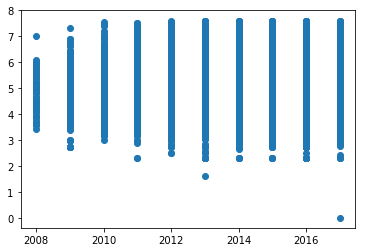

In [56]:
plt.scatter(listings.year_of_listing, listings.log_price)

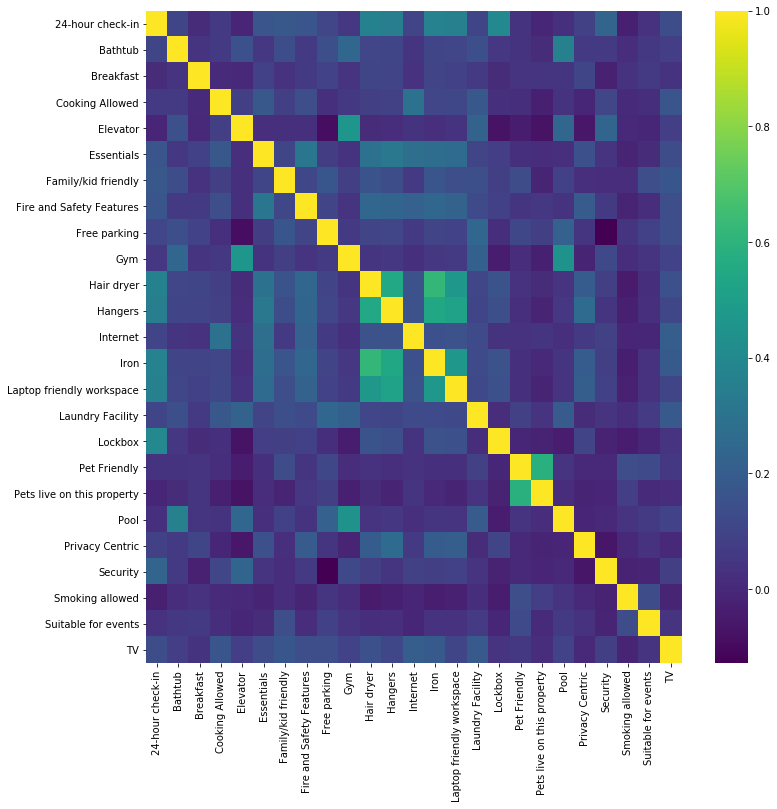

In [57]:
## Generating the heatmap for visualization - using Seaborn
fig = plt.figure(figsize= (12,12))
sns.heatmap(listings_selected_amenities.corr(), annot=False, vmax=1, cmap='viridis', square=False)

### Visualization of target variables

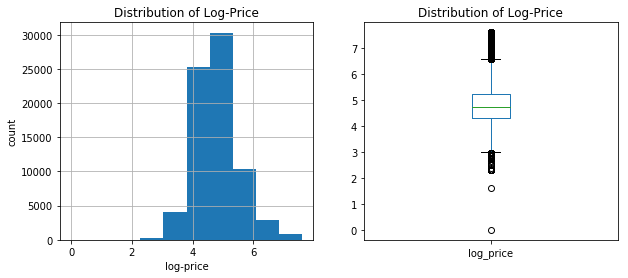

In [58]:
# The Log Price column
fig = plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

listings.log_price.hist(ax = ax1)
ax1.set_title('Distribution of Log-Price')
ax1.set_xlabel('log-price')
ax1.set_ylabel('count')

# The Log Price column
plot = listings.log_price.plot(kind = 'box', ax = ax2)
ax2.set_title('Distribution of Log-Price')

plt.show()

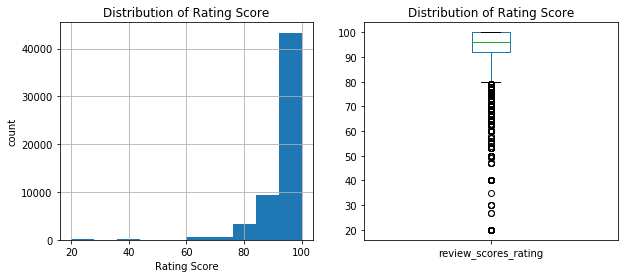

In [59]:
# The Log Price column
fig = plt.figure(figsize = (10,4))

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

listings.review_scores_rating.hist(ax = ax1)
ax1.set_title('Distribution of Rating Score')
ax1.set_xlabel('Rating Score')
ax1.set_ylabel('count')

# The Log Price column
plot = listings.review_scores_rating.plot(kind = 'box', ax = ax2)
ax2.set_title('Distribution of Rating Score')

plt.show()

## Modelling - Listing Price

In [60]:
listings.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
       'instant_bookable', 'last_review', 'latitude', 'longitude', 'name',
       'Neighbourhood', 'number_of_reviews', 'review_scores_rating',
       'thumbnail_url', 'zipcode', 'bedrooms', 'beds', 'dist_to_attr1',
       'dist_to_attr2', 'dist_to_attr3', 'dist_to_station', 'year_of_listing',
       'month_of_listing', 'days_since_hosted', 'price', 'bedroom_share',
       'bathroom_share', 'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'city_Boston', 'city_Chicago', 'city_DC',
       'city_LA', 'city_NYC', 'city_SF', 'property_type_Apartment',
       'property_type_House', 'property_type_other_prop_type',
       'bed_type_Real Bed', 'bed_type_other_bed_type',
       'can

In [61]:
np.random.seed(2018)
train = np.random.choice([True, False], listings.shape[0], replace=True, p=[0.5, 0.5])
listings_train = listings.iloc[train,:]
listings_test = listings.iloc[~train,:]


In [144]:
train_cols = [
       'accommodates', 'description_length', 'dist_to_attr1',
       'dist_to_attr2', 'dist_to_attr3', 'dist_to_station',  'days_since_hosted','city_Boston', 'city_Chicago', 'city_DC',
       'city_LA', 'city_NYC', 'room_type_Entire home/apt', 'room_type_Private room','property_type_Apartment',
       'property_type_House', 'cancellation_policy_flexible', 'cancellation_policy_moderate', 'cancellation_policy_strict', '24-hour check-in', 'Bathtub',
       'Breakfast', 'Cooking Allowed', 'Elevator', 'Essentials',
       'Family/kid friendly', 'Fire and Safety Features', 'Free parking',
       'Gym', 'Hair dryer', 'Hangers', 'Internet', 'Iron',
       'Laptop friendly workspace', 'Laundry Facility', 'Lockbox',
       'Pet Friendly', 'Pets live on this property', 'Pool', 'Privacy Centric',
       'Security', 'Smoking allowed', 'Suitable for events', 'TV','bed_type_Real Bed','bedroom_share'
       
        ]
target_col = 'log_price'
removed_cols = ['id', 'log_price', 'property_type', 'room_type', 'amenities','bathrooms', 'bed_type', 'cancellation_policy'
       , 'city', 'first_review', 'host_has_profile_pic','year_of_listing', 'last_review', 'latitude', 'longitude', 'name',
       'Neighbourhood', 'number_of_reviews', 'review_scores_rating',
       'thumbnail_url', 'zipcode', 'bedrooms', 'beds',
       'month_of_listing','host_identity_verified', 'host_response_rate', 'host_since',  'days_since_hosted', 'price', 
       'bed_type_other_bed_type'
       , 'property_type_other_prop_type','instant_bookable',
       'room_type_Shared room','bathroom_share','cleaning_fee'
       ]
x_train = listings_train[train_cols].values
x_test = listings_test[train_cols].values
y_train = listings_train[target_col].values
y_test = listings_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(37068, 46) (36855, 46) (37068,) (36855,)


### Linear Regression Model

In [145]:
# Declare an instance of the Linear Regression model.
lm = LinearRegression()

# Fit the model on to the training data( Train the model ).
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [146]:
# Check the R^2 value of the model.
print("R^2 value using score fn: %.3f" % lm.score(x_test,y_test))

R^2 value using score fn: 0.581


In [147]:
# Use the model to predict values
y_pred = lm.predict(x_test)

In [148]:
# Calculate the Mean Squared Error using the mean_squared_error function.
mean_squared_error(y_test,y_pred)


0.21475595279842785

In [149]:
print(lm.intercept_, lm.coef_)

3925.3333336179144 [ 1.26815324e-01 -5.49311460e-04 -5.61073333e-03 -1.78711887e-02
 -1.15914527e-02  3.04460886e-02  3.57072015e-05 -3.32568867e-01
 -5.66970325e-01 -3.29492661e-01  2.25499503e-01 -1.94753929e-01
  1.05978158e+00  4.90656511e-01 -1.19933715e-01  1.34053857e-02
 -3.92116496e+03 -3.92121792e+03 -3.92120300e+03 -5.46869224e-02
  1.95394156e-02  4.61940820e-02 -5.51597475e-02  6.13839414e-02
 -1.64363348e-02  1.80054298e-02 -2.24759500e-02  5.04569691e-03
  6.66096126e-02  4.32355247e-02 -3.46915127e-02 -1.12523776e-01
 -1.04000759e-02 -5.32956099e-03  7.58863788e-02 -3.82974965e-02
 -5.17412919e-03  1.06028138e-02  7.81669813e-02 -3.32843038e-02
  3.38313178e-02 -4.13225313e-02  7.72237145e-02  1.36887291e-01
  1.03114417e-02  1.99135582e-01]


In [150]:
y_pred.shape

(36855,)

C:\Users\Manu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Residuals for the model')

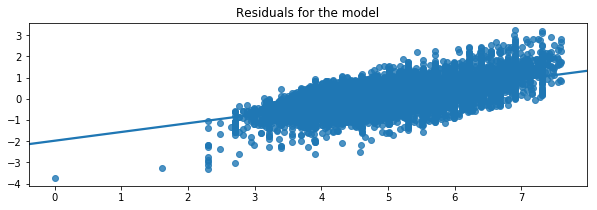

In [152]:
# Plot of Casual and Registered model's residuals:
fig = plt.figure(figsize=(10,3))

sns.regplot(y_test,y_test - y_pred)
plt.title("Residuals for the model")


## Modelling - Review Rating Score

### Binning Review Ratings 

In [153]:
#Drop rows with missing values in RATINGS columns
listings_classification = listings.dropna(axis=0, subset = ['review_scores_rating'])

We can bin the Review ratings based on 3 approaches
- Based on values
- Based on number of data points in the bins
- Based on Clustering

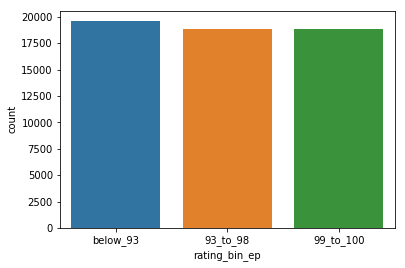

In [154]:
# Create equal probability bins at the PENTILES of RATING
listings_classification = listings_classification.assign(
    rating_bin_ep = pd.qcut(
        listings_classification['review_scores_rating'],
        q=3,
        duplicates='drop',
        labels=['below_93', '93_to_98', '99_to_100']
    )
)

# Visualize the Split
sns.countplot(listings_classification['rating_bin_ep'])

In [155]:
listings_classification['rating_bin_ep'].value_counts()

below_93     19614
93_to_98     18833
99_to_100    18801
Name: rating_bin_ep, dtype: int64

### Regression as Classification


In [156]:
show_cols_with_missing(listings_classification)


host_response_rate    9245
zipcode                413
first_review             1
last_review              1
dtype: int64

In [157]:
listings_classification.columns

Index(['id', 'log_price', 'property_type', 'room_type', 'amenities',
       'accommodates', 'bathrooms', 'bed_type', 'cancellation_policy',
       'cleaning_fee', 'city', 'first_review', 'host_has_profile_pic',
       'host_identity_verified', 'host_response_rate', 'host_since',
       'instant_bookable', 'last_review', 'latitude', 'longitude', 'name',
       'Neighbourhood', 'number_of_reviews', 'review_scores_rating',
       'thumbnail_url', 'zipcode', 'bedrooms', 'beds', 'dist_to_attr1',
       'dist_to_attr2', 'dist_to_attr3', 'dist_to_station', 'year_of_listing',
       'month_of_listing', 'days_since_hosted', 'price', 'bedroom_share',
       'bathroom_share', 'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'city_Boston', 'city_Chicago', 'city_DC',
       'city_LA', 'city_NYC', 'city_SF', 'property_type_Apartment',
       'property_type_House', 'property_type_other_prop_type',
       'bed_type_Real Bed', 'bed_type_other_bed_type',
       'can

In [158]:
# Drop the rows with missing values for particular columns
listings_classification.dropna(subset = ['host_response_rate'], inplace = True)

listings_classification.rating_bin_ew = listings_classification.rating_bin_ew.astype(str)
listings_classification.rating_bin_km = listings_classification.rating_bin_km.astype(str)

In [160]:
np.random.seed(2018)
train = np.random.choice([True, False], listings_classification.shape[0], replace=True, p=[0.7, 0.3])

listings_classification_train = listings_classification.iloc[train,:]
listings_classification_test = listings_classification.iloc[~train,:]

train_cols = listings_classification.select_dtypes([np.number,bool]).columns.drop(['review_scores_rating', 'number_of_reviews','latitude', 'longitude',
                                                                                   'month_of_listing','year_of_listing', 'lda_transport','lda_amenities',
                                                                                   'lda_property_desc'])
target_col = 'rating_bin_ep'

x_train = listings_classification_train[train_cols].values
x_test = listings_classification_test[train_cols].values
y_train = listings_classification_train[target_col].values
y_test = listings_classification_test[target_col].values

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
           

(33765, 64) (14238, 64) (33765,) (14238,)


## Decision tree

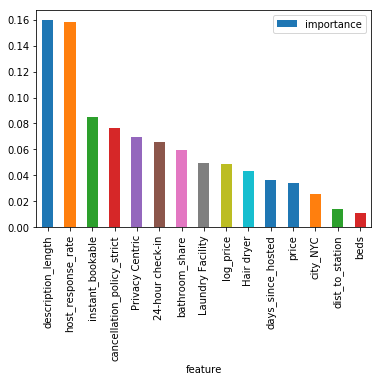

In [161]:
#Make the decision tree
dtree = DecisionTreeClassifier(
    class_weight="balanced",
    min_weight_fraction_leaf=0.01)

dtree.fit(x_train,y_train)

importances = dtree.feature_importances_
feat_names = train_cols
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:15].plot(x='feature', y='importance', kind='bar')

In [162]:
#Get Decision Tree mean squared error on test dataset
dtree_y_predict = dtree.predict(x_test)

print("Score: %.3f" % dtree.score(x_test,y_test))

print('Precision: %0.2f \nRecall: %0.2f \nF1 Score: %0.2f' %
      (precision_score(y_test, dtree_y_predict, average='weighted'),
       recall_score(y_test, dtree_y_predict, average='weighted'),
       f1_score(y_test, dtree_y_predict, average='weighted'))
     )

conf_mat_df = pd.DataFrame(data=confusion_matrix(y_test, dtree_y_predict), 
                           columns=['p_below_93', 'p_93_to_98', 'p_99_to_100'],
                           index=['below_93', '93_to_98', '99_to_100'])
conf_mat_df

Score: 0.441
Precision: 0.44 
Recall: 0.44 
F1 Score: 0.44


,p_below_93,p_93_to_98,p_99_to_100
below_93,1990,1467,1704
93_to_98,1122,1927,1262
99_to_100,1137,1264,2365


## Random Forest

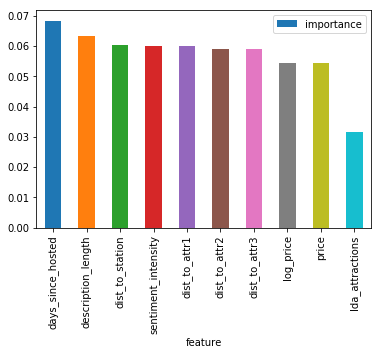

In [163]:
# Random Forest Model
rf = RandomForestClassifier(
    n_estimators=1000, 
    max_depth=30, 
    min_samples_split=10, 
    class_weight="balanced"
    )

rf.fit(x_train, y_train)
importances = rf.feature_importances_
feat_names = train_cols
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
tree_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar')

In [164]:
#Get Random Forest mean squared error on test dataset
rf_y_predict = rf.predict(x_test)

print("Score: %.3f" % rf.score(x_test,y_test))

print('Precision:', precision_score(y_test, rf_y_predict, average='weighted'),
      "Recall:", recall_score(y_test, rf_y_predict, average='weighted'), 
      "F1 Score:", f1_score(y_test, rf_y_predict, average='weighted'))

conf_mat_df = pd.DataFrame(data=confusion_matrix(y_test, rf_y_predict), 
                           columns=['p_below_93', 'p_93_to_98', 'p_99_to_100'],
                           index=['below_93', '93_to_98', '99_to_100'])
conf_mat_df

Score: 0.504
Precision: 0.5037887031429578 Recall: 0.504424778761062 F1 Score: 0.5036846309506656


,p_below_93,p_93_to_98,p_99_to_100
below_93,2733,1086,1342
93_to_98,1442,1904,965
99_to_100,1267,954,2545


show_cols_with_missinglistings_classification.info()
